This is a starter file of network simulation.
To start, you can change the section that are labeled with **[User]**


Check file folder:

In [1]:
%matplotlib inline
import os
from pypvcircuit.config_tool import user_config_data

In [2]:
if os.path.exists("/data"):
    default_data_path="/data"
else:
    default_data_path="./public_data"
default_savedata_path= user_config_data['Path_config']['output_path']

## [USER] Set file path of mask profile

In [3]:
mask_filepath=os.path.join(default_data_path,'masks_sq.png')

## [USER] Set illumination profile
The parameter ```profile``` can be either ```from_file``` or ```uniform```.
```from_file```: load illumination profile from a file
```uniform```: the profile is uniform

In [4]:
profile='uniform'

In [5]:
illumination_filepath=os.path.join(default_data_path,'masks_illumination.png')
peak_concentration=200

You have to set concentration if you want the profile to be uniform, i.e., ```profile=uniform```

In [6]:
concentration=700

## [USER] Set the folder name for storing output data

In [7]:
save_data_path=default_savedata_path

## [USER] Set solar cell parameters

In [8]:
# Size of the pixels (m)
l_r = 1e-6
l_c = 1e-6

h=2.2e-6

# Start voltage
vini = -0.1
# End voltage
vfin = 3.5
# Voltage step
step = 0.01

# cell temperature in Kelvins
T = 298

lump_series_r=0

## [USER] Set the merged pixel width


In [9]:
rw=10 #row-direction
cw=10 #columne-direction

## [USER] Select the solar cell model
Set ```solar_cell_model``` to `1` if you would like to assume that the subcells have ideal efficiencies. Set the solar cell model to `2` if you would like to use assign the EQEs.

In [10]:
solar_cell_model=1

If you set ```solar_cell_model=1```, you have to assign the following model:

In [11]:
top_cell_eg=1.87
middle_cell_eg=1.42
bottom_cell_eg=0.93

If you set ```solar_cell_model=2```, you have to assign the EQE file

In [12]:
# Load QE
#QE_file="private_data/xx.csv" #Solar junction cell: QE_SJ
top_eqe_file=os.path.join(default_data_path,"demo_eqe_top.csv")
mid_eqe_file=os.path.join(default_data_path,"demo_eqe_mid.csv")
bot_eqe_file=os.path.join(default_data_path,"demo_eqe_bot.csv")

## [USER] Set the external radiative efficiency
This parameter affects the voltages of the cell.

In [13]:
top_cell_rad_eta=5e-3
middle_cell_rad_eta=1e-2
bottom_cell_rad_eta=1e-4

### [USER] Set the light source
spectrum can be AM1.5g or AM1.5d

In [14]:
illumination_spectrum="AM1.5g" # this value can be "AM1.5g" or "AM1.5d"

## Import the required packages

In [15]:
import numpy as np

import copy
import matplotlib.pyplot as plt

from skimage.io import imread
from pypvcell.fom import ff,isc,voc
from pypvcell.solarcell import SQCell,MJCell,DBCell
from pypvcell.illumination import load_astm
from pypvcell.spectrum import Spectrum

from pypvcircuit.meshing import get_merged_r_image

In [16]:
def to_data_path(filename):
    return os.path.join(save_data_path,filename)

## Load the pattern of the contact

In [17]:
contactsMask = imread(mask_filepath, as_gray=True)

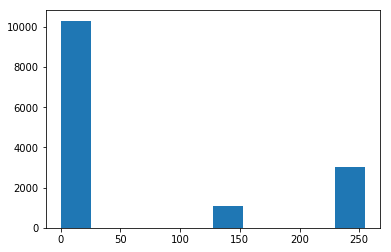

In [20]:
plt.hist(contactsMask.ravel())
plt.show()

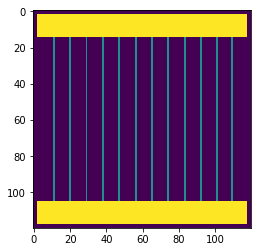

In [18]:
plt.imshow(contactsMask)

## Reduce the shape to 1/2 because of symmetry

In [19]:
nx, ny = contactsMask.shape
contactsMask = contactsMask[:, int(ny / 2):]

In [20]:
nx

120

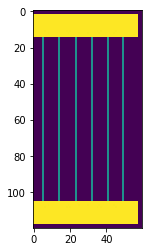

In [21]:
plt.imshow(contactsMask)

## Make illumination

Load the illumination profile. The file can be either a PNG file or a comma sepearted file.

In [22]:
# both csv and png file are supported.
image_file=illumination_filepath
#image_file=join(this_path,"Illumination profile_20180926_random.csv")

In [23]:
def load_illumination(fname):
    _,ext=os.path.splitext(fname)
    ext=ext[1:].lower()
    if (ext=='png'):
        img=imread(fname)
        if img.ndim==3:
            img=img[:,:,0]
    elif (ext=='csv'):
        img=np.loadtxt(fname,delimiter=',')
    return img

In [24]:
one_sun_illumination=np.ones((nx,ny))*concentration

In [25]:
if profile=="uniform":
    img=one_sun_illumination
elif profile=="from_file":
    img=load_illumination(image_file)
    #img=img.astype(np.float)*peak_concentration/np.max(img)
else:
     raise ValueError("The value of profile can be either *uniform* or *from_file*")

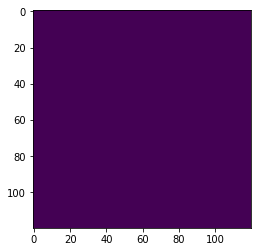

In [26]:
plt.imshow(img)

### Show statistics of the profile

Show histogram of pixel values

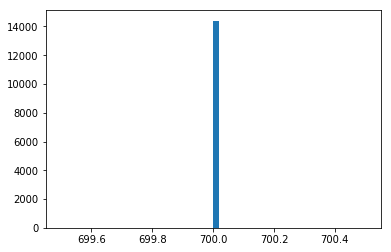

In [27]:
plt.hist(img.ravel(),bins=50)
plt.show()

Total of the pixel value:

In [28]:
value_sum=np.sum(img)
print("The sum of total pixel value: {}".format(value_sum))

The sum of total pixel value: 10080000.0


In [29]:
pixel_photon_unit=1.1426e11
print("The sum of photon number: {}".format(value_sum*pixel_photon_unit))

The sum of photon number: 1.1517408e+18


### Reduce the shape to 1/2

In [30]:
illuminationMask=img
illuminationMask=illuminationMask[:, int(img.shape[1] / 2):]

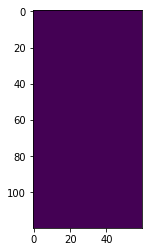

In [31]:
plt.imshow(illuminationMask)

In [32]:
np.max(illuminationMask)

700.0

In [33]:
illuminationMask.shape

(120, 60)

### Option 1: detailed-balanced limit
This solar cell solver calculates the saturation current J01 and J02 from detail balanced model (assuming 100% aborptivity). Sheet resistance is assigned by the user.

In [34]:
# the solar cell parameters

gaas_cell = SQCell(middle_cell_eg, T, middle_cell_rad_eta)
ingap_cell = SQCell(top_cell_eg, T, top_cell_rad_eta)
ge_cell = SQCell(bottom_cell_eg, T, bottom_cell_rad_eta)


# assign which solar cell to use. For example, to use top cell, set my_solar_cell like this:
# my_solar_cell=SolarCell([ingap_cell],T=T)
# For full 3J solar cell, the parameter is like this:
# my_solar_cell=SolarCell([ingap_cell,gaas_cell,ge_cell],T=T)
solar_cell_1 = MJCell([ingap_cell,gaas_cell,ge_cell])

### Option 2: solar cell with known EQE

Use the following code snippets if your EQE file has four columns: wavelength, top cell EQE, middle cell EQE, bottom cell EQEs
```
all_EQE=np.loadtxt(QE_file,delimiter=',',skiprows=1)
#eliminate the QE values <0
for i in range(1,all_EQE.shape[1]):
    c=np.nonzero(all_EQE[:,i]<0)
    all_EQE[c,i]=0

start_idx=0
end_idx=all_EQE.shape[0]
top_cell_eqe=Spectrum(x_data=all_EQE[start_idx:end_idx,0],y_data=all_EQE[start_idx:end_idx,1],x_unit='nm')
mid_cell_eqe=Spectrum(x_data=all_EQE[start_idx:end_idx,0],y_data=all_EQE[start_idx:end_idx,2],x_unit='nm')
bot_cell_eqe=Spectrum(x_data=all_EQE[start_idx:end_idx,0],y_data=all_EQE[start_idx:end_idx,3],x_unit='nm')
```

In [35]:
top_eqe=np.loadtxt(top_eqe_file,delimiter=',',skiprows=1)
mid_eqe=np.loadtxt(mid_eqe_file,delimiter=',',skiprows=1)
bot_eqe=np.loadtxt(bot_eqe_file,delimiter=',',skiprows=1)

Convert the EQE from percentages to numerics

In [36]:
top_eqe[:,1]=top_eqe[:,1]/100
mid_eqe[:,1]=mid_eqe[:,1]/100
bot_eqe[:,1]=bot_eqe[:,1]/100

In [37]:
top_cell_eqe=Spectrum(x_data=top_eqe[:,0],y_data=top_eqe[:,1],x_unit='nm')
mid_cell_eqe=Spectrum(x_data=mid_eqe[:,0],y_data=mid_eqe[:,1],x_unit='nm')
bot_cell_eqe=Spectrum(x_data=bot_eqe[:,0],y_data=bot_eqe[:,1],x_unit='nm')

In [38]:
gaas_db_cell=DBCell(mid_cell_eqe,rad_eta=middle_cell_rad_eta,T=T,eg=1.4)
ingaas_db_cell=DBCell(bot_cell_eqe,rad_eta=bottom_cell_rad_eta,T=T,eg=0.93)
ingap_db_cell=DBCell(top_cell_eqe,rad_eta=top_cell_rad_eta,T=T,eg=1.87)
solar_cell_2=MJCell([ingap_db_cell,gaas_db_cell,ingaas_db_cell])

In [39]:
gaas_db_cell.j01_r

1.1090535895329757e-15

In [40]:
if solar_cell_model==1:
    my_solar_cell=solar_cell_1
elif solar_cell_model==2:
    my_solar_cell=solar_cell_2

In [41]:
illuminationMask.shape

(120, 60)

In [42]:
contactsMask.shape

(120, 60)

Set the solar spectrum

In [43]:
my_solar_cell.set_input_spectrum(load_astm(illumination_spectrum)) 

### Launch the solver

In [44]:
from pypvcircuit.parse_spice_input import NodeReducer
from pypvcircuit.spice_solver import SPICESolver

nd = NodeReducer()

In [45]:
%time
sps = SPICESolver(solarcell=my_solar_cell, illumination=illuminationMask,
                  metal_contact=contactsMask, rw=rw, cw=cw, v_start=vini, v_end=vfin,
                  v_steps=step,l_r=l_r,l_c=l_c, h=h, spice_preprocessor=nd,lump_series_r=lump_series_r)

Wall time: 0 ns
number of data:361


### Voltage map

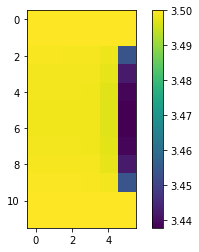

In [46]:
plt.imshow(sps.get_end_voltage_map())
plt.colorbar()

### Downsampled image

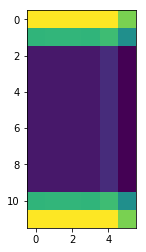

In [47]:
r_image=get_merged_r_image(contactsMask,rw,cw)
plt.imshow(r_image)

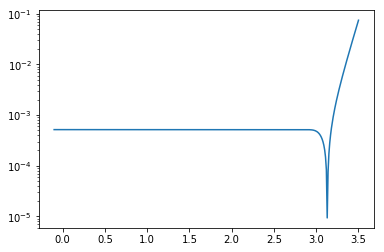

In [48]:
plt.semilogy(sps.V, abs(sps.I))
plt.show()

## Plot in linear scale

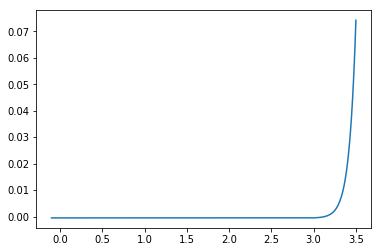

In [49]:
plt.plot(sps.V, sps.I)

Zoom in to negative current

(-0.0005660663161999999, 0)

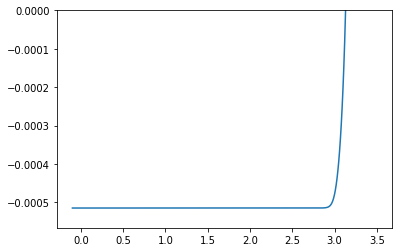

In [50]:
plt.plot(sps.V, sps.I)
plt.ylim([np.min(sps.I)*1.1,0])

In [51]:
isc_value=isc(sps.V,sps.I)*2
print("Isc:{}".format(isc_value))

Isc:-0.0010292114839999997


In [52]:
voc_value=voc(sps.V,sps.I)
print("Voc:{}".format(voc_value))

Voc:3.131100129497397


In [53]:
ff_value=ff(sps.V,sps.I)
print("FF:{}".format(ff_value))

FF:0.9303960509464434


## Export the I-V characteristics into a CSV file

The result is written into the file ```iv_result.csv```

In [54]:
output_iv=np.vstack([sps.V,sps.I]).T
np.savetxt(to_data_path('iv_result.csv'),output_iv,delimiter=',')

## Compare simulation with different grid sizes

In [55]:
test_pws=[10,5,2]
file_prefix="3j_pana_"

Wall time: 0 ns
number of data:361
number of data:361
number of data:361


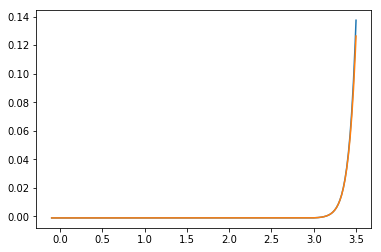

In [56]:
%time
result_vi=None
for pw in test_pws:
    nd = NodeReducer()

    sps = SPICESolver(solarcell=my_solar_cell, illumination=illuminationMask,
                  metal_contact=contactsMask, rw=pw, cw=pw, v_start=vini, v_end=vfin,
                  v_steps=step,l_r=l_r,l_c=l_c, h=h, spice_preprocessor=nd)

    # Since we model 1/4 of the device, we multiply the current by 4
    sps.I = sps.I * 2
    np.save(to_data_path("{}_vmap_{}.npy".format(file_prefix, pw)), sps.get_end_voltage_map())

    if result_vi is None:
        result_vi = np.stack((sps.V, sps.I))
    else:
        result_vi = np.vstack((result_vi, sps.V, sps.I))
        plt.plot(sps.V, sps.I, label="pw: {}".format(pw))

In [57]:
np.savetxt(to_data_path("{}_3j_iv.csv".format(file_prefix)), result_vi.T,
                   delimiter=',')

plt.savefig(to_data_path("{}_1jfig.png".format(file_prefix)))

<Figure size 432x288 with 0 Axes>

fill factor of pw 10: 0.9304
fill factor of pw 5: 0.9304
fill factor of pw 2: 0.9304


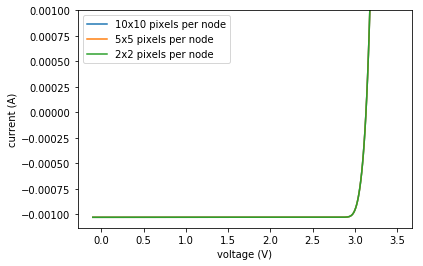

In [58]:
iv=np.loadtxt(to_data_path("{}_3j_iv.csv").format(file_prefix),delimiter=',')
for i in range(0,iv.shape[1],2):
    plt.plot(iv[:,i],iv[:,i+1],label="{0}x{0} pixels per node".format(test_pws[i//2]))
    iv_ff=ff(iv[:,i],iv[:,i+1])
    print("fill factor of pw {}: {:.4f}".format(test_pws[i//2],iv_ff))
plt.ylim((np.min(iv[:,1])*1.1,0.001))
plt.xlabel("voltage (V)")
plt.ylabel("current (A)")
plt.legend()
plt.savefig(to_data_path("iv_fig.png"),dpi=300)

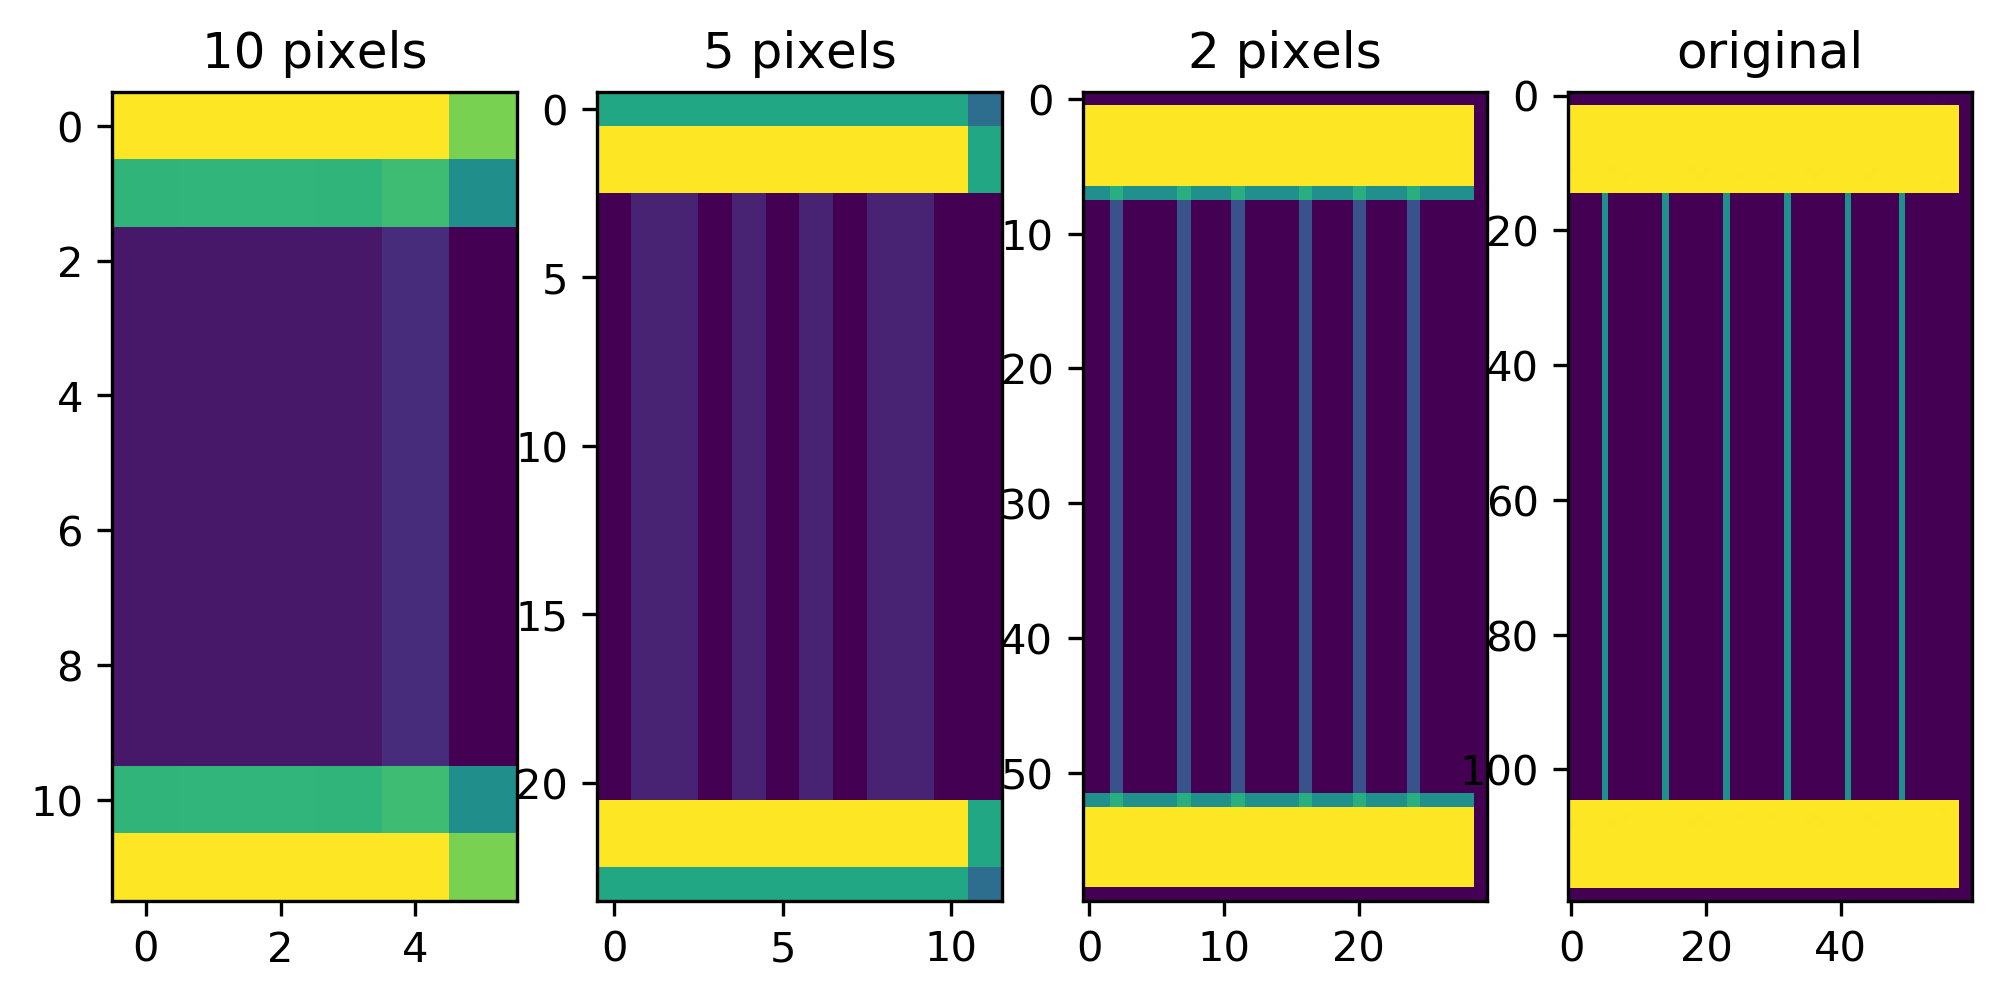

In [59]:
fig,ax=plt.subplots(ncols=len(test_pws)+1,figsize=(8,6),dpi=300)
for i, pw in enumerate(test_pws): 
    r_image=get_merged_r_image(contactsMask,pw,pw)
    ax[i].imshow(r_image)
    ax[i].set_title("{} pixels".format(pw))
r_image=get_merged_r_image(contactsMask,1,1)
ax[-1].imshow(r_image)
ax[-1].set_title("original")
fig.savefig(to_data_path("equiv_r_images.png"))

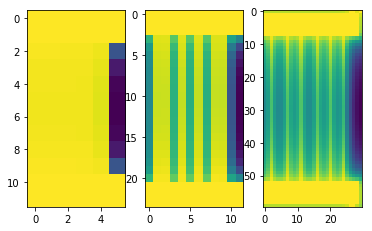

In [60]:
fig,ax=plt.subplots(ncols=len(test_pws))
for i, pw in enumerate(test_pws):
    vmap=np.load(to_data_path('{}_vmap_{}.npy').format(file_prefix,pw))
    ax[i].imshow(vmap)